In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import XUV_signal_computation2 as XUV_sig
import XUV_refractive_index as XUV_index
import mynumerics as mn
import harmonic_signal as hs

['Ar_Henke', 'Ar_NIST', 'He_Henke', 'He_NIST', 'Kr_Henke', 'Kr_NIST', 'Ne_Henke', 'Ne_NIST', 'Xe_Henke', 'Xe_NIST']


#### Illustration figures presented in the article



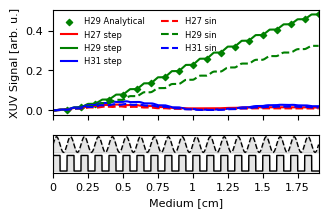

In [2]:
# FIGURE 3 - SIGNAL BUILDUP FOR INTRODUCTION
# common parameters
wavelength = 800e-9 # [m]
omegaSI = mn.ConvertPhoton(wavelength, 'lambdaSI', 'omegaSI') 
period = 0.001 # [m]
gas = "Ar"
order = 29
centp = 0.05 # [bar]
eta = 0 # ionization degree between 0-1 [-]; pm is 0.04378
# control parameters
xi_f = 1.0 
pressure = centp*2 # 100e-3 #50e-3 # 25e-3 #1.0 # 42e-3
l1 = period/2
delta_phi = np.pi/order # this is the dephasing

parameters = {'XUV_table_type_dispersion': 'NIST',
              'XUV_table_type_absorption': 'Henke',
              'gas_type': gas,
              'omegaSI': omegaSI,
              'Aq' : 1.0}

def asymptotic_signal(p,omega):
    return 4.*((p*parameters['Aq'])**2)*XUV_index.L_abs(omega, pressure, parameters["gas_type"] + '_' + parameters["XUV_table_type_absorption"])**2

# RUNNING THE CALCULATION ====================
# medium definitions
steps = 500
# grid for the analytical model
M_grid = np.arange(1, 20)
# z space grid for numerical model
zaxis = np.linspace(0, (len(M_grid))*period, (len(M_grid))*steps) # [m]

# pressure vectors for numerical model
pr_step = hs.modstep(centp, period, zaxis, ratio=0.5)
pr_sin = hs.modsin(centp, 1, period, zaxis)

# laser definitions
order = np.arange(27, 32, 2)

# analytical model calculation
zeta_f = XUV_sig.zeta_chain_pm(delta_phi, pressure, l1, xi_f, eta, 29, parameters)
signal = XUV_sig.periodic_medium_signal(pressure, zeta_f, l1, xi_f, eta, 29, M_grid, parameters)[1]

# numerical model calculation
geo = hs.fullmodel(2*np.pi, period, wavelength, 29, centp, "Ar", eta, parameters) # geometrical phase
int_step = np.zeros([zaxis.shape[0], order.shape[0]])
int_sin = np.zeros([zaxis.shape[0], order.shape[0]])

for i, val in enumerate(order):
    int_step[:,i] = hs.hh_signal_dk(zaxis, pr_step, gas, eta, wavelength, val, geo, parameters) # sinus medium
    int_sin[:,i] = hs.hh_signal_dk(zaxis, pr_sin, gas, eta, wavelength, val, geo, parameters) # step medium

# normalization signal
sig_norm = asymptotic_signal(pressure,29*omegaSI)

# plot settings
cm = 1/2.54  # centimeters in inches
scale = 1
figsize = (scale*8.6*cm, scale*5.8*cm)
fontsize = 8

# PLOT ====================
colors = ("r", "g", "b")
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize, gridspec_kw={"height_ratios": [2.8, 1]}, sharex=True, facecolor="w")
# subplot 0
for i in range(int_step.shape[1]): # plot sinus medium from numerical model
    ax[0].plot(zaxis, int_step[:,i]/sig_norm, label=("H"+str(order[i]) + " step"), color=colors[i], linestyle="-")
# plot analytical model
ax[0].scatter(np.arange(period, 20*period, period), signal/sig_norm, label="H29 Analytical", color="g", marker="D", s=10)
for i in range(int_step.shape[1]): # plot step medium from numerical model
    ax[0].plot(zaxis, int_sin[:,i]/sig_norm, label=("H"+str(order[i])+ " sin"), color=colors[i], linestyle="--")
#get handles and labels
handles, labels = ax[0].get_legend_handles_labels()
#specify order of items in legend
order = [3,0,1,2,4,5,6]
#add legend to plot
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=fontsize-2, ncol=2, frameon=False)
ax[0].set_ylabel("XUV Signal [arb. u.]", fontsize=fontsize)
ax[0].tick_params(axis="both", labelsize=fontsize)
# subplot 1
ax[1].set_yticks([])
ax[1].plot(zaxis, (pr_sin/2 + centp + 0.01), color="k", linestyle="--", linewidth=1)
ax[1].fill_between(zaxis, ((pr_sin/2 + centp+ 0.01)/np.max((pr_sin/2 + centp+ 0.01)))*np.max((pr_sin/2 + centp+ 0.01)), centp+ 0.01, alpha=0.1, color="k")
ax[1].plot(zaxis, pr_step/2, color="k", linewidth=1)
ax[1].fill_between(zaxis, (pr_step/2/np.max(pr_step/2))*np.max(pr_step/2), 0, alpha=0.1, color="k")
ax[1].set_xlabel("Medium [cm]", fontsize=fontsize)
ax[1].tick_params(axis="both", labelsize=fontsize)
ax[1].set_xticks([0, 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175])
ax[1].set_xticklabels([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75])
ax[1].set_xlim([0, zaxis[-1]])
plt.tight_layout()
plt.savefig("fig3.png", dpi=600)
plt.show()

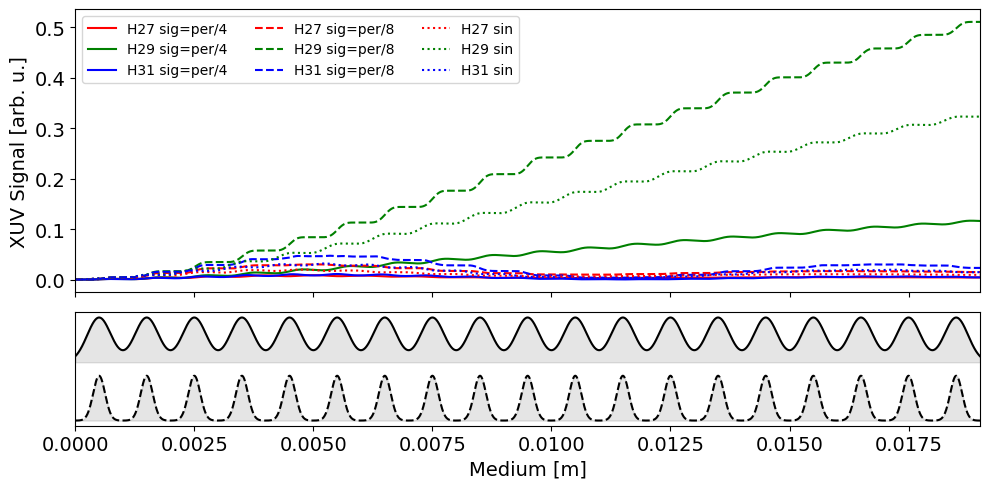

In [3]:
# PLOT OF GAUSSIAN TRAIN PRESSURE
# calculation is using some variables from previous cell, needs to be run together
order = np.arange(27, 32, 2)

div_1 = 4
div_2 = 8

pr_gauss_1 = hs.modgauss(centp, period, zaxis, period/div_1)
pr_gauss_2 = hs.modgauss(centp, period, zaxis, period/div_2)

int_gauss_1 = np.zeros([zaxis.shape[0], order.shape[0]])
int_gauss_2 = np.zeros([zaxis.shape[0], order.shape[0]])
for i, val in enumerate(order):
    int_gauss_1[:,i] = hs.hh_signal_dk(zaxis, pr_gauss_1, gas, eta, wavelength, val, geo, parameters) # step medium
    int_gauss_2[:,i] = hs.hh_signal_dk(zaxis, pr_gauss_2, gas, eta, wavelength, val, geo, parameters) # step medium

colors = ("r", "g", "b")
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5), gridspec_kw={"height_ratios": [2.5, 1]}, sharex=True, facecolor="w")
# subplot 0
for i in range(int_step.shape[1]): # plot sinus medium from numerical model
    ax[0].plot(zaxis, int_gauss_1[:,i]/sig_norm, label=(f"H{order[i]} sig=per/{div_1}"), color=colors[i], linestyle="-")
for i in range(int_step.shape[1]): # plot step medium from numerical model
    ax[0].plot(zaxis, int_gauss_2[:,i]/sig_norm, label=(f"H{order[i]} sig=per/{div_2}"), color=colors[i], linestyle="--")
for i in range(int_step.shape[1]): # plot step medium from numerical model
    ax[0].plot(zaxis, int_sin[:,i]/sig_norm, label=("H"+str(order[i])+ " sin"), color=colors[i], linestyle=":")

ax[0].legend(fontsize=10, ncol=3)
ax[0].set_ylabel("XUV Signal [arb. u.]", fontsize=14)
ax[0].tick_params(axis="both", labelsize=14)

ax[1].set_yticks([])
ax[1].plot(zaxis, pr_gauss_1/np.max(pr_gauss_1) + 1.3, color="k", linestyle="-")
ax[1].fill_between(zaxis, ((pr_gauss_1/np.max(pr_gauss_1) + 1.3)/np.max((pr_gauss_1/np.max(pr_gauss_1) + 1.3)))*np.max((pr_gauss_1/np.max(pr_gauss_1) + 1.3)), 1.3, alpha=0.1, color="k")
ax[1].plot(zaxis, pr_gauss_2/np.max(pr_gauss_2), color="k", linestyle="--")
ax[1].fill_between(zaxis, ((pr_gauss_2/np.max(pr_gauss_2))/np.max((pr_gauss_2/np.max(pr_gauss_2))))*np.max((pr_gauss_2/np.max(pr_gauss_2))), alpha=0.1, color="k")
ax[1].set_xlabel("Medium [m]", fontsize=14)
ax[1].tick_params(axis="both", labelsize=14)
ax[1].set_xlim([0, zaxis[-1]])
plt.tight_layout()
plt.show()

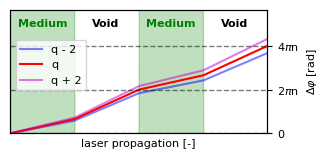

In [4]:
# FIGURE 1 - ILLUSTRATIVE DELTA K CUMMULATION
# medium definition
period = 0.001
z = np.linspace(0, 2*period-0.0000001, 1000) # the 0.0000001 is there to limit the plot in x
pressure = 0.03 #[bar]
gas = "Ar"
eta = 0.0
# define pressure modulation
med = hs.modstep(pressure, period, z, ratio=0.5)

# define parameters
parameters = {'XUV_table_type_dispersion': 'NIST',
              'XUV_table_type_absorption': 'Henke',
              'gas_type': gas,
              'omegaSI': omegaSI,
              'Aq' : 1.0}

# HH
laser = 800e-9

# optimal geometrical phase
geo = hs.fullmodel(2*np.pi, period, laser, 29, pressure, gas, eta, parameters)

# Calculations below this line
# divided by pi to have it in units of pi, and getting rid of the complex values
dkcum_27 = np.abs(hs.dk_cumulation(z, med, gas, laser, 27, eta, geo, parameters)/np.pi)
dkcum_29 = np.abs(hs.dk_cumulation(z, med, gas, laser, 29, eta, geo, parameters)/np.pi)
dkcum_31 = np.abs(hs.dk_cumulation(z, med, gas, laser, 31, eta, geo, parameters)/np.pi)


# plot settings
cm = 1/2.54  # centimeters in inches
scale = 1
figsize = (scale*8.6*cm, scale*4.3*cm)
fontsize = 8

# PLOT THE DATA
fig, ax = plt.subplots(figsize=figsize, facecolor="w")
# positions of y ticks
ytck = np.arange(0, np.max(dkcum_31), 2, dtype=int)
# dk accumulation
axy = ax.twinx() 
axy.plot(z, dkcum_27, color="b", alpha=0.5, label="q - 2")
axy.plot(z, dkcum_29, color="r", label="q")
axy.plot(z, dkcum_31, color="m", alpha=0.5, label="q + 2")
# color where medium is present
ax.fill_between(z, med*100, 0, alpha=0.25, color="g")
# horizontal lines at multiples of 2pi
axy.hlines(ytck, xmin=0, xmax=np.max(z), color="k", linestyles="--", linewidth=1, alpha=0.5)
# ticks
ax.set_yticks([])
ax.set_xticks([])
axy.set_yticks(ytck)
axy.set_yticklabels(["0", "2$\pi$n", "4$\pi$n"])
axy.tick_params(axis="both", labelsize=fontsize)
ax.tick_params(axis="both", labelsize=fontsize)
# xlim and ylim
ax.set_ylim([0, 1.8*np.pi])
axy.set_ylim([0, 1.8*np.pi])
ax.set_xlim([0, 2*period])
# labels and legend
ax.set_xlabel("laser propagation [-]", fontsize=fontsize)
axy.set_ylabel("$\\Delta \\varphi$ [rad]", fontsize=fontsize)
axy.legend(loc="upper left", bbox_to_anchor=(0, 0.8), fontsize=fontsize)
# text 
ax.text(x=0.03, y=0.86, s="Medium", fontsize=fontsize, fontweight="bold", color="g", transform=ax.transAxes)
ax.text(x=0.53, y=0.86, s="Medium", fontsize=fontsize, fontweight="bold", color="g",  transform=ax.transAxes)
ax.text(x=0.32, y=0.86, s="Void", fontsize=fontsize, fontweight="bold", transform=ax.transAxes)
ax.text(x=0.82, y=0.86, s="Void", fontsize=fontsize, fontweight="bold", transform=ax.transAxes)

plt.tight_layout()
plt.savefig("fig1.png", dpi=600)
plt.show()